In [1]:
import params as par
from background import *


import numba
from scipy.special import spherical_jn
from scipy import integrate
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from mpl_toolkits import mplot3d
plt.rcParams.update(par.plot_params)
cp = copy.deepcopy

In [2]:
# Load data from GDM_FID.

τ_solve = pickle.load(open("data/tau_solve.p", "rb"))
k_solve = pickle.load(open("data/k_solve.p", "rb"))

wd_F = pickle.load(open("data/w_d.p", "rb"))
Dwd_F = pickle.load(open("data/Dw_d.p", "rb"))
cs2d_F = pickle.load(open("data/cs2_d.p", "rb"))

δd = pickle.load(open("data/delta_d.p", "rb"))
vd = pickle.load(open("data/v_d.p", "rb"))
δɣ = pickle.load(open("data/delta_g.p", "rb"))
vɣ = pickle.load(open("data/v_g.p", "rb"))
Φ = pickle.load(open("data/phi.p", "rb"))


(wd, Dwd, cs2d) = (wd_F, Dwd_F, cs2d_F)

N = len(τ_solve)

In [3]:
"""2 fluid"""

# set initial conditions
Φ0 = Φ[:, 0]
δɣ0 = δɣ[:, 0]
vɣ0 = vɣ[:, 0]
δd0 = δd[:, 0]
vd0 = vd[:, 0]

Y0 = np.array([Φ0, δɣ0, vɣ0, δd0, vd0])

# @numba.jit(nopython=True)


def DY(τ, Y, wd, Dwd, cs2d, Ωd_, H_, a_):
    dY = np.zeros((5, K_SOLVE))
    Φ = Y[0, :]
    δɣ = Y[1, :]
    vɣ = Y[2, :]
    δd = Y[3, :]
    vd = Y[4, :]

    # compute background quantities
    ℋi = 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)
    ai = a(τ)
    Ωdi = Ωc0 * ai**-3. + Ων0 * ai**-4.
    ℋi = H_(τ)
    ai = a_(τ)
    Ωdi = Ωd_(τ)
    ybi = 1.68*ai*Ωb0/Ωr0

    Ωbi = Ωb0 * ai**-3.
    Ωɣi = Ωɣ0 * ai**-4.

    wdi = np.interp(τ, τ_solve, wd)
    Dwdi = np.interp(τ, τ_solve, Dwd)

    # interpolate cs2
    idx = np.searchsorted(τ_solve, τ) - 1
    d = (τ - τ_solve[idx]) / (τ_solve[idx + 1] - τ_solve[idx])
    cs2di = (1 - d) * cs2d[:, idx] + cs2d[:, idx + 1] * d

    f = vd*Ωdi*(1+wdi) + 4./3.*Ωɣi*vɣ + Ωbi*vɣ
    dY[0, :] = -ℋi*Φ + (3/2.*H0**2.*ai**2/k_solve)*f
    dY[1, :] = -4./3.*k_solve*vɣ + 4*dY[0, :]
    dY[2, :] = (-ℋi*ybi*vɣ + k_solve*δɣ/3)/(
        4./3. + ybi) + k_solve*Φ
    dY[3, :] = -(1+wdi)*(k_solve*vd-3*dY[0, :]) -\
        3*ℋi*(cs2di-wdi)*δd
    dY[4, :] = -ℋi*(1-3*wdi)*vd - vd*Dwdi/(1+wdi) +\
        k_solve*δd*cs2di/(1+wdi) + k_solve*Φ
    return dY

In [4]:
# compute stepsizes for RK4
stepsizes = np.diff(τ_solve)
a_list = a_eq*((α*τ_solve/τr)**2 + 2*α*τ_solve/τr)
Ωd_τ0 = Ωc(τ0)+Ων(τ0)
a_list = a(τ_solve)


# implement RK4
# @numba.jit(nopython=True) # (NOTE: re-implement cumtrapz to put these back)
def solve(wd, Dwd, cs2d):
    # Update the background:
    Ωd_a = Ωd_τ0 * np.exp(-3 *
                          integrate.cumtrapz((1+wd)/a_list, a_list, initial=0)
                          )
    H_a = H0 * np.sqrt(Ωb0*a_list**-3 + Ωɣ0*a_list**-4 + Ωd_a + ΩΛ)*a_list
    τ_a = integrate.cumtrapz(1/(a_list * H_a), a_list, initial=0)+τ0
    a_ = interp1d(τ_a, a_list, kind='quadratic', fill_value='extrapolate')
    H_ = interp1d(τ_a, H_a, kind='quadratic', fill_value='extrapolate')
    Ωd_ = interp1d(τ_a, Ωd_a, kind='quadratic', fill_value='extrapolate')

    Y = np.zeros((len(τ_solve), 5, par.K_SOLVE))
    Y[0, :, :] = Y0
    for i, τi in enumerate(τ_solve[:-1]):
        ss = stepsizes[i]
        k1 = ss*DY(τi, Y[i, :, :], wd, Dwd, cs2d, Ωd_, H_, a_)
        k2 = ss*DY(τi+ss/2, Y[i, :, :]+k1/2, wd, Dwd, cs2d, Ωd_, H_, a_)
        k3 = ss*DY(τi+ss/2, Y[i, :, :]+k2/2, wd, Dwd, cs2d, Ωd_, H_, a_)
        k4 = ss*DY(τi+ss, Y[i, :, :]+k3, wd, Dwd, cs2d, Ωd_, H_, a_)

        Y[i+1, :, :] = Y[i, :, :] + k1/6 + k2/3 + k3/3 + k4/6
    return Y

In [5]:
# k and l list for integration
k_list2 = np.linspace(k_low, k_high, K_INT)
l_list = np.array([i for i in range(2, 50, 1)]+[i for i in range(50, 200, 5)] +
                  [i for i in range(200, 2500, 20)])
L = len(l_list)

"""Precompute Bessel Functions"""
# check if they're already stored
if 'DJLK' not in globals():
    JLK = np.array([
        spherical_jn(l, k_list2*(τ_now-τ_rec))
        for l in l_list])
    DJLK = np.array([
        spherical_jn(l, k_list2*(τ_now-τ_rec), derivative=True)
        for l in l_list])

In [6]:
k_grid = np.broadcast_to(k_list2, (len(l_list), K_INT))
τ0_Mpc = 2.3e4*τ0


# @numba.jit(nopython=True)
def get_Cl(wd, Dwd, cs2d, params):
    As = params[0]
    # first compute mode evolution:
    Yf = solve(wd, Dwd, cs2d)[-1, :, :]
    SW = Yf[0, :] + Yf[1, :]/4
    ISW = ΔΦ
    DOP = Yf[2, :]

    SWsd = (SW+ISW)*np.exp(-(k_solve*τs)**2)
    DOPsd = DOP*np.exp(-(k_solve*τs)**2)

    # get the power spectrum
    SWfill = np.interp(k_list2, k_solve, SW)
    DOPfill = np.interp(k_list2, k_solve, DOP)
    Dl = SWfill*JLK + DOPfill*(DJLK-JLK/(2*k_list2*(τ_now-τ_rec)))

    T = np.exp(-2*(k_list2*τs)**2 - (.03*k_list2*τ_rec)**2)
    Cl_itgd = Dl**2 * T / k_list2
    Cl = integrate.trapz(k_grid, Cl_itgd)
    norm = 4*np.pi * As/(k_star**(ns-1)) * TCMB0**2 * (1/3 * τ0_Mpc**2)**2
    norm = 4*np.pi * As * TCMB0**2
    Cl_normed = l_list*(l_list + 1)*Cl * norm/(2*np.pi)
    return np.abs(Cl_normed)

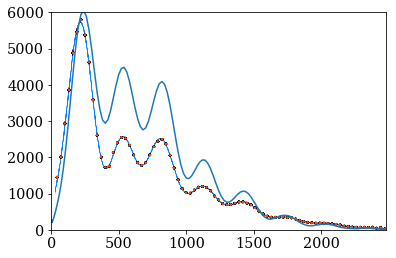

In [7]:
params_F = [As]
if True:
    """Compare to Planck 2015"""
    Cl0 = get_Cl(wd_F, Dwd_F, cs2d_F, params_F)
    plt.plot(l_list, Cl0/2, zorder=1)
    im = plt.imread('img/Cl_planck_30p.PNG')
    plt.imshow(im, extent=[30, 2500, 0, 6000], zorder=0, aspect='auto')
    plt.xlim(0, l_list[-1])
    plt.show()

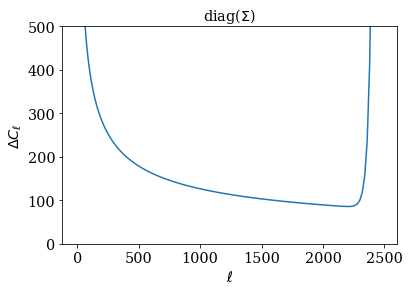

In [8]:
# Error:
f_sky = 1.0  # fraction of sky
l_s = 500.  # filtering scale
theta_pix = 0.0012  # rad
sigma_pix = 16.e-6
wbar = 1/(0.33e-15)
B_cl = np.exp(-l_list*(l_list + 1)/l_s**2)

ΔCl2 = (2/((2*l_list+1)*f_sky)) * (Cl0 + wbar**(-1) * B_cl**-2)**2
ΔCl2 = (2/((2*l_list+1)*f_sky)) * (4000 + wbar**(-1) * B_cl**-2)**2
Sigma = np.diag(ΔCl2)

plt.plot(l_list, np.sqrt(ΔCl2))
plt.title(r'diag($\Sigma$)')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell$')
plt.ylim(0, 500)
plt.show()

(4096,) (256,)


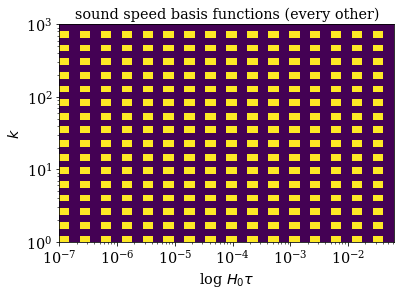

[  8 128]


In [10]:
(K,N) = np.shape(cs2d_F)
(NCk,NCx) = (32,32)
NC = NCk * NCx
B = np.zeros((NCk,NCx,K,N))
k,n = np.mgrid[0:K,0:N]
wk,wx = K//NCk, N//NCx
for i in range(NCk):
    for j in range(NCx):
        B[i,j,wk*i:wk*(i+1),wx*j:wx*(j+1)]=1
        
# plot the basis functions:
Bplt = np.zeros((K,N))
idx = 0
for i in range(0,NCk,2):
    for j in range(0,NCx,2):
        Bplt += B[i,j]
        x,y = np.transpose(np.nonzero(B[i,j]))[0]
        #print(x,y)
        #plt.text(x,y+10,str(idx))
        idx+=2

#plt.imshow(Bplt,extent=[0,K,0,N],aspect='auto',origin='lower')
#plt.pcolormesh([τ_solve,k_solve],Bplt)
print(np.shape(τ_solve),np.shape(k_solve))
plt.pcolormesh(τ_solve,k_solve,Bplt)
plt.loglog()

plt.title('sound speed basis functions (every other)')
plt.xlabel(r'log $H_0 \tau$')
plt.ylabel(r'$k$')
plt.show()
print(np.transpose(np.nonzero(B[1,1]))[0])
# flatten the basis functions:
B_flt = B.reshape(NCk*NCx, K,N)

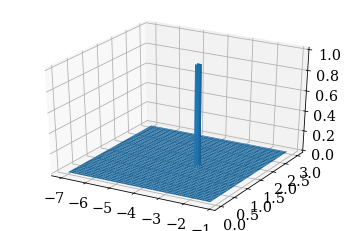

In [65]:
ss = 0.01
J = np.zeros((L, NC))
for n in range(NC):
    Δcs2d = B_flt[n]*ss
    Cl_fwd = get_Cl(wd_F, Dwd_F, cs2d + Δcs2d, params_F)
    Cl_bwd = get_Cl(wd_F, Dwd_F, cs2d - Δcs2d, params_F)
    J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
    if(n % 5 == 0):
        print(str(n) +' of '+str(NC))

0 of 1024
5 of 1024
10 of 1024
15 of 1024


KeyboardInterrupt: 

(32, 32)


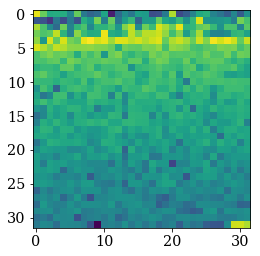

In [57]:
J = pickle.load(open("data/cs2_1024.p", "rb"))
F = J.T @ Sigma @ J
u, s, v = np.linalg.svd(F)
PV = np.real(u)  # principal vectors
"""
print(np.shape(PV),np.shape(B_flt))
PC = np.zeros((NC, K, N))
for i in range(NC):
    PC[i] = np.sum(PV[i])
    
PC = np.einsum('ijk,il', B_flt, PV)
print(np.shape(PC))
"""
"""
plt.pcolormesh(τ_solve,k_solve,-PC[:,:,3])
#plt.semilogx()
plt.title('sound speed PC 4')
plt.xlabel(r'log $H_0 \tau$')
plt.ylabel(r'$k$')
plt.colorbar()
plt.show()
"""
PC = np.reshape(PV[1], (32,32))
print(np.shape(PC))
plt.imshow(np.log(abs(PC)))
#plt.show()

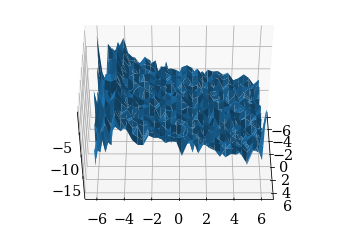

In [64]:

x = np.linspace(-6, 6, 32)
y = np.linspace(-6, 6, 32)
X, Y = np.meshgrid(τ_solve,k_solve)
X, Y = np.meshgrid(x,y)
Z = np.sin(np.sqrt(X**2 + Y**2))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(45, 0)
#ax.contour3D(np.log10(X), np.log10(Y), B_flt[40], 50, cmap='binary')
ax.plot_surface(X, Y, np.log(abs(PC)))

plt.show()

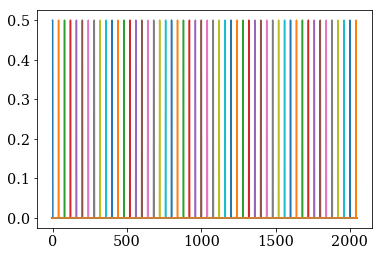

0.01 1000.0


In [14]:
"""cs2-only PCA"""
from numpy import sin, cos, pi



def pca(t, basis_type, N_C, clip=False):
    τ_clip = τ0*2

    # set derivative stepsize
    ss = 1*10**(1-t)

    # filenames:
    Bname = basis_type+"-"+str(N_C)
    Jname = "cs2_J_t"+"-"+str(t)+"_"+Bname
    PCname = "cs2_PC_t"+"-"+str(t)+"_"+Bname
    SVname = "cs2_SV_t"+"-"+str(t)+"_"+Bname
    if clip:
        Bname = Bname + "_c"
        Jname = Jname + "_c"
        PCname = PCname + "_c"
        SVname = SVname + "_c"


    print('computing partials:')
    J = np.zeros((L, N_C))
    for n in range(N_C):
        Δcs2d = B_flt[n]*ss
        Cl_fwd = get_Cl(wd_F, Dwd_F, cs2d + Δcs2d, params_F)
        Cl_bwd = get_Cl(wd_F, Dwd_F, cs2d - Δcs2d, params_F)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
        if(n % 5 == 0):
            print(str(n) + ' of ' + str(N_C))

    # save the partials matrix and the basis matrix
    pickle.dump(J, open("data/"+Jname+".p", "wb"))
    pickle.dump(B, open("data/"+Bname+".p", "wb"))

    print('Partials saved. Computing PCs')
    try:
        # get PCs
        F = np.transpose(J)@np.linalg.inv(Sigma)@J
        u, s, v = np.linalg.svd(F)
        D, V = np.linalg.eig(F)
        PV = np.real(u)  # principal vectors
        PC = B@PV

        # flip and normalize the PCs
        for i in range(N_C):
            loc = np.argmax(np.abs(PC[:, i]))
            PC[:, i] *= np.sign(PC[loc, i])
            PC[:, i] /= np.linalg.norm(PC[:, i])

        pickle.dump(s, open("data/"+SVname+".p", "wb"))
        pickle.dump(PC, open("data/"+PCname+".p", "wb"))
        print('PCs saved.')
    except:
        print('svd failed')


N_C = 1024
B = np.zeros((N, N_C))
width = N//N_C
for n in range(N_C):
    B[width*(n):width*(n+1), n] = 1/width
plt.plot(B[:, ::20])
plt.show()
  

In [ ]:
"""
for t in range(7, 12):
    for l2n in range(4, 10):
        N_C = 2**l2n
        print('square basis', 't = '+str(t), 'N_C = '+str(N_C))
        pca(t, 'square', N_C, clip=True)

        print('cosine basis', 't = '+str(t), 'N_C = '+str(N_C))
        pca(t, 'cosine', N_C, clip=True)

        print('gaussian basis', 't = '+str(t), 'N_C = '+str(N_C))
        pca(t, 'gaussian', N_C, clip=True)

        print('sinc basis', 't = '+str(t), 'N_C = '+str(N_C))
        pca(t, 'sinc', N_C, clip=True)
    pca(t, 'std', N)
"""

square basis t = 7 N_C = 16
computing partials:
0 of 16
5 of 16
10 of 16
15 of 16
Partials saved. Computing PCs
PCs saved.
cosine basis t = 7 N_C = 16
computing partials:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


0 of 16
5 of 16
10 of 16
15 of 16
Partials saved. Computing PCs
PCs saved.
gaussian basis t = 7 N_C = 16
computing partials:
0 of 16
5 of 16
10 of 16
15 of 16
Partials saved. Computing PCs
PCs saved.
sinc basis t = 7 N_C = 16
computing partials:
0 of 16
5 of 16
10 of 16
15 of 16
Partials saved. Computing PCs
PCs saved.
square basis t = 7 N_C = 32
computing partials:
0 of 32
5 of 32
10 of 32
15 of 32
20 of 32
25 of 32
30 of 32
Partials saved. Computing PCs
PCs saved.
cosine basis t = 7 N_C = 32
computing partials:
0 of 32
5 of 32
10 of 32
15 of 32
20 of 32
25 of 32
30 of 32
Partials saved. Computing PCs
PCs saved.
gaussian basis t = 7 N_C = 32
computing partials:
0 of 32
5 of 32
10 of 32
15 of 32
20 of 32
25 of 32
30 of 32
Partials saved. Computing PCs
PCs saved.
sinc basis t = 7 N_C = 32
computing partials:
0 of 32
5 of 32
10 of 32
15 of 32
20 of 32
25 of 32
30 of 32
Partials saved. Computing PCs
PCs saved.
square basis t = 7 N_C = 64
computing partials:
0 of 64
5 of 64
10 of 64
15 of 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide



0 of 256
5 of 256
10 of 256
15 of 256
20 of 256
25 of 256
30 of 256
35 of 256
40 of 256
45 of 256
50 of 256
55 of 256
60 of 256
65 of 256
70 of 256
75 of 256
80 of 256
85 of 256
90 of 256
95 of 256
100 of 256
105 of 256
110 of 256
115 of 256
120 of 256
125 of 256
130 of 256
135 of 256
140 of 256
145 of 256
150 of 256
155 of 256
160 of 256
165 of 256
170 of 256
175 of 256
180 of 256
185 of 256
190 of 256
195 of 256
200 of 256
205 of 256
210 of 256
215 of 256
220 of 256
225 of 256
230 of 256
235 of 256
240 of 256
245 of 256
250 of 256
255 of 256
Partials saved. Computing PCs
PCs saved.
square basis t = 7 N_C = 512
computing partials:
0 of 512
5 of 512
10 of 512
15 of 512
20 of 512
25 of 512
30 of 512
35 of 512
40 of 512
45 of 512
50 of 512
55 of 512
60 of 512
65 of 512
70 of 512
75 of 512
80 of 512
85 of 512
90 of 512
95 of 512
100 of 512
105 of 512
110 of 512
115 of 512
120 of 512
125 of 512
130 of 512
135 of 512
140 of 512
145 of 512
150 of 512
155 of 512
160 of 512
165 of 512
170 of 

In [47]:
%prun get_Cl(wd_F, Dwd_F, cs2d_F, params_F)